**Task**

The second worksheet of file 'takehome20902data.xlsx' contains Put and Call options' delta, gamma and price for several strikes.

The underlying futures prices (E-MINI S&P500 futures dec 2024) and the "continuous" futures price series are also provided.

All options, and the corresponding futures, expire on dec 15th 2023.

For details on the security definitions and CME exchange go to

https://www.cmegroup.com/markets/equities/sp/e-mini-sandp500.html

The purpose of the exercise is to define a "statistical" hedging policy, based on the futures, which tries to "beat" the simple delta hedging (deltas and gammas are given for comparison).

The futures track the forward, not the spot of the underlying, this has implications on hedging. Hedging should be done option by option.

We use the first 300 observations for training the model and the rest of the sample for testing.

The Colab notebook
1. computes the result of delta hedging each option using the provided deltas.
2. builds an alternative (deep) hedging proposal.
3. compares the results.
4. comments 1-3.

The dynamic hedging problem under consideration can be described as the task of finding, at each point in time $t$, the optimal underlying asset weight $\delta_t^*$, that is
$$
\delta^* := \{ \delta_t^* \}_{t=0}^T = \arg \min_{\delta} \rho \left(
  PL_{T}
  \right)
$$ where
+ $PL_{T}$ is the dynamic profit-loss account at the end of the time horizon;
+ $\rho$ is a risk measure

We test two different risk measures:
- MSE: $\rho (X)=\mathbb{E}(X^2) $
- Semi-MSE: $\rho (X)=\mathbb{E}(X^2 \mathbb{1}_{X>0} )$; this latter choice does not penalize "beneficial" errors.

We begin with delta-hedging using the provided option deltas, then move on to apply ANN architectures to try and improve the result.

**1. Delta-hedging strategy**


This strategy is based on the Black-Scholes model of derivative pricing, which informs investors on how to use derivatives' "delta", that is the change in a derivative's price following a unitary change in the underlying asset price. Such method prescribes to buy $\delta$ units of the underlying asset in order to hedge the (one-)option position.

In [ ]:
# ========================== INSTALL LIBRARIES ========================== #

!pip install openpyxl
!pip install numpy
!pip install pandas
!pip install -q -U keras-tuner
!pip install tensorflow
!pip install sklearn

In [ ]:
# ========================== MODULE IMPORT ========================== #
import math
import random
from datetime import datetime
import os, openpyxl
from google.colab import drive

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn import set_config

import tensorflow as tf
import keras_tuner as kt

import matplotlib.pyplot as plt

In [ ]:
# =========== reset backend, set random seed and diagram display =========== #
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(42)
set_config(display='diagram')

In [ ]:
# ========================== PREPARATORY BLOCK ========================== #

# Option lists for later reference

strikes = [4000, 4200, 4400, 4600, 4800] # list of option strikes, useful later
options = [f'CALL ISM DEC23 {strike}' for strike in strikes] + \
          [f'PUT ISM DEC23 {strike}' for strike in strikes]

# Extract option features from option

def option_features(option,i = 0, M = 1):
  '''
  Returns:
  option_net_payoff: net option change in value wrt day before
  strike: option strike price
  M: option position for calls and puts, set opposite one other
  option_type: whether it is a call or a put
  '''

  strike = int(option.split()[-1])
  option_type = option.split()[0]

  if option_type == 'CALL':
    M = M
    option_net_payoff = prices_df[option].iloc[i]-prices_df[option].iloc[i-1]
    #option_net_payoff = max(price_fut.iloc[i+1] - strike,0)-prices_df[option].iloc[i]
  elif option_type == 'PUT':
    M = -M
    option_net_payoff = prices_df[option].iloc[i]-prices_df[option].iloc[i-1]
    #option_net_payoff = max(strike - price_fut.iloc[i+1],0)-prices_df[option].iloc[i]

  return option_net_payoff, strike, M, option_type



# ======================= LOSS FUNCTIONS FINAL VERSION ======================= #

def mse_pf_loss(y_true, y_pred):
  '''
  Calculates outcome of prediction on profit-loss.
  Returns MSE of profit-loss.
  '''

  y = y_true[:, :-1] # shape (None,10) like y_pred (10 neurons in output layer)
  S_shift = y_true[:, -1:] # shape (None,1): only contains underlying price shifts

  result_profitloss = -1 * (S_shift * (y - y_pred)) # Assume M = -1
  squared_errors = tf.square(result_profitloss)

  mse_per_option = tf.reduce_mean(squared_errors, axis=0)
  # tensor with 1 mse value for each option

  loss = tf.reduce_mean(mse_per_option) # average out across options
  return loss

def rmse_pf_loss(y_true,y_pred):
  loss = tf.sqrt(mse_pf_loss(y_true,y_pred))
  return loss

# ========================== MLP HYPERMODEL BUILD ========================== #

def build_model(hp):
  n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
  n_neurons = hp.Int("n_neurons", min_value=64, max_value=512)
  learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")

  optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
  if optimizer == 'sgd':
    tf.keras.optimizers.SGD(learning_rate = learning_rate)
  else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model_MLP = tf.keras.Sequential()
  for _ in range(n_hidden):
    model_MLP.add(tf.keras.layers.Dense(n_neurons, activation="relu"))

  activation = hp.Choice("activation", values=["sigmoid", "tanh",""])
  if activation == 'sigmoid':
    model_MLP.add(tf.keras.layers.Dense(10, activation="sigmoid"))
  elif activation == 'tanh':
    model_MLP.add(tf.keras.layers.Dense(10, activation="tanh"))
  else:
    model_MLP.add(tf.keras.layers.Dense(10)) # no activation function

  model_MLP.compile(loss=mse_pf_loss, optimizer=optimizer, metrics=rmse_pf_loss)

  return model_MLP

class MLP_HyperModel(kt.HyperModel):
  def build(self, hp):
    return build_model(hp)

  def fit(self, hp, model_MLP, X, y, **kwargs):
    if hp.Boolean("normalize"):
        norm_layer = tf.keras.layers.Normalization()
        X = norm_layer(X)

    history = model_MLP.fit(X, y, shuffle=True, **kwargs)
    return history

# ======================= FIT + EVALUATE MODELS ======================= #

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mse_pf_loss", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=rmse_pf_loss, optimizer=opt, metrics=rmse_pf_loss)
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_rmse = model.evaluate(valid_set)
    return valid_rmse

In [ ]:
#===================== DRIVE MOUNT and Data Preparation ===================== #

drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Fintech20902_year_2024/'
file_name = 'takehome20902data.xlsx'
file_path = os.path.join(os.getcwd(), file_name)

df = pd.read_excel(file_path, sheet_name='question2 data')
df.set_index('Date',inplace=True)

# delta values for 11-24-2022 are not sensible and only distort results;
# it seems to be the only data point with such issues, so I used this workaround
# and avoided using more complex threshold logics for delta recalculation
knn = KNeighborsRegressor(n_neighbors=3)
for option in options:
  X = np.arange(len(df)).reshape(-1, 1)
  y = df[option + ' - OPTION DELTA'].values.reshape(-1, 1)
  knn.fit(X[:df.index.get_loc('2022-11-24')], y[:df.index.get_loc('2022-11-24')])
  interpolated_delta = knn.predict([[df.index.get_loc('2022-11-24')]])[0][0]
  df.at['2022-11-24', option + ' - OPTION DELTA'] = interpolated_delta

ready_df = df # stores dataset ready for running operations
ready_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Fintech20902_year_2024


,CME-MINI S&P 500 INDEX CONT. - SETT. PRICE,CME-MINI S&P 500 INDEX DEC 2023 - SETT. PRICE,Date.1,CALL ISM DEC23 4000 - OPTION DELTA,CALL ISM DEC23 4000 - OPTION GAMMA,CALL ISM DEC23 4000,PUT ISM DEC23 4000 - OPTION DELTA,PUT ISM DEC23 4000 - OPTION GAMMA,PUT ISM DEC23 4000,CALL ISM DEC23 4200 - OPTION DELTA,...,CALL ISM DEC23 4600,PUT ISM DEC23 4600 - OPTION DELTA,PUT ISM DEC23 4600 - OPTION GAMMA,PUT ISM DEC23 4600,CALL ISM DEC23 4800 - OPTION DELTA,CALL ISM DEC23 4800 - OPTION GAMMA,CALL ISM DEC23 4800,PUT ISM DEC23 4800 - OPTION DELTA,PUT ISM DEC23 4800 - OPTION GAMMA,PUT ISM DEC23 4800
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-07,4190.25,4230.0,2022-03-07,0.62207,0.00027,648.25,-0.36184,0.00027,422.25,0.56248,...,327.25,-0.55386,0.00033,691.00,0.36114,0.00033,244.00,-0.62535,0.00034,804.75
2022-03-08,4160.50,4210.0,2022-03-08,0.61612,0.00028,632.25,-0.36693,0.00027,426.00,0.55559,...,313.50,-0.56203,0.00034,696.75,0.35209,0.00033,232.75,-0.63396,0.00034,813.00
2022-03-09,4266.75,4322.0,2022-03-09,0.64605,0.00026,702.50,-0.33710,0.00026,386.25,0.58824,...,363.00,-0.52447,0.00033,636.00,0.38887,0.00033,274.00,-0.59586,0.00034,743.50
2022-03-10,4248.00,4303.0,2022-03-10,0.64089,0.00027,686.50,-0.34167,0.00026,389.25,0.58224,...,351.50,-0.53134,0.00033,643.00,0.38148,0.00033,264.75,-0.60294,0.00034,752.75
2022-03-11,4192.50,4248.0,2022-03-11,0.62607,0.00027,654.25,-0.35631,0.00027,411.00,0.56627,...,326.50,-0.55017,0.00034,671.75,0.36242,0.00033,242.75,-0.62278,0.00034,784.75


In [ ]:
# ======================= EXTRA CODE: Time to expiry ======================= #
# not needed since Options track the Futures at same maturity

date_format = "%Y-%m-%d"

start_dates = df['Date.1'].astype(str).apply(lambda x: datetime.strptime(x, date_format))
expiry=datetime.strptime('2023-12-15',date_format) # as per instructions

tte = expiry-start_dates #time to expiry
#print(days_inbtw[:4].index)

It is important to note that, since all traded options are written on the same underlying future with same date as options' expiry, we can safely ignore interest rate considerations in (re-)hedging evaluations: the role of the risk-free asset and its rate do not affect the final value of the future with regard to the option position. For computational ease, let's assume in general that $r = 0$ throughout all periods.

---

**Delta Neutral Portfolio**

Let $S_t, C_t, P_t$ represent, respectively, the underlying futures price, the premium on a Call option written on it, and that of a corresponding Put.

When the price of the underlying asset rises, the strike price of a Call option becomes more appealing, whereas that of a Put option becomes less appealing. This implies $ C_t \propto S_t $ and $P_t \propto - S_t $. These different relationships are, however, already taken into account in the definition of delta. Let now $c_t$ represent the price of a generic option (call or put) written on the underlying. We have that the period $t$'s Profit/Loss account is

$$
\Delta W_t = NS_t + M c_t - (NS_{t-1} + M c_{t-1}) = 0 \\
\Downarrow \\
N (S_t- S_{t-1}) + M (c_t -c_{t-1}) = 0 \\
\Downarrow \\
N = M \left( - \frac{\Delta c_t}{\Delta S_t} \right)
$$

Indeed, $\Delta c_t/\Delta S_t$ is positive for Calls and negative for Puts. We will therefore set the *hedge ratio* $h$ for all options in each period equal to $$h^*=M/N=- \frac{\Delta S}{\Delta C} = - \frac{1}{\delta}$$
or, equivalently
$$
N = - \delta M
$$

Portfolio value at $t$ is
$$
W_t = N_t S_t + M C_t = M ( C_t - \delta_t S_t )
$$

under the Delta-hedging strategy. The target risk exposure is zero: we evaluate the hedging error using $MSE= \frac{1}{T-1} \sum_{t=1}^T ( \Delta W_t )^2 $ where $t$ denotes the t-th trading day, and $\Delta W_t = W_t - W_{t-1} $

**Portfolio Rebalancing and Profit-Loss**

Unless we rely on a "hedge and forget" strategy (not very efficient), the above implies that, in every period after the first one, we update the hedging policy for each option depending on daily changes in $\delta$:

\begin{align}
\Delta N_t & = N_t - N_{t-1} \\
& = - \delta_t M - (- \delta_{t-1} M) = - \left( \Delta \delta_t \right) M
\end{align}

In other words, we have to set $h^*$ again every day, depending on the updated $\delta$ value. The rebalancing outflow value each day is equal to the current market value of the underlying security addition to the hedge position; since it is an outflow when the position goes longer, it appears as negative:

$$
REB_t = - \left( N_t S_t - N_{t-1} \right) S_t = - \left(\Delta N_t \right) S_t = \Delta \delta_t M S_t
$$

Then profit-loss at the end of each period is equal to the overall change in portfolio value, net of the cash outflow needed to rebalance:

\begin{align}
PL_t & = \Delta W_t + REB_t = W_t - W_{t-1} + REB_t \\
& = \underbrace{M ( \color{red}{- \delta_t S_t} + C_{t} )}_{W_t} - \underbrace{ \color{blue}{M (- \delta_{t-1} S_{t-1}} + C_{t-1})}_{W_{t-1}} + \underbrace{( \color{red}{\delta_t} \color{blue}{- \delta_{t-1} ) M S_t}}_{REB_{t}} \\
& = \color{blue}{- \delta_{t-1} M \Delta S_t } + M \Delta C_t
= M \left(\Delta C_t - \delta_{t-1} \Delta S_t \right) \\
& = M \Delta S_t \left(- \delta_{t-1} + \frac{\Delta C_t}{\Delta S_t} \right)
\end{align}

Essentially, the rebalancing expenditure $REB_t$ and its effect on portfolio value in each period cancel each other out, so that $PL_t$ effectively depends solely on hedging effectiveness. Note that by assumption in this strategy

$$
\mathbb{E}(\Delta C_t / \Delta S_t ) = \delta_{t-1} \Rightarrow
\mathbb{E}( PL_t ) = 0
$$

It is important to recall that in practice we must distinguish between

The cumulative profit-loss account at $T$ then is
\begin{align}
PL_T & = \sum_{t=1}^T PL_t = \sum_{t=1}^T \left( W_t-W_{t-1} + REB_t \right) \\
& = W_T - W_0 + \sum_{t=1}^T \Delta \delta_t M S_t \\
& = M \left( \delta_T S_T - \delta_0 S_0 + C_T - C_0 + \sum_{t=1}^T \Delta \delta_t S_t \right)
\end{align}


In [ ]:
# =============== DELTA-HEDGING + PERFECT HEDGING COMPUTATION =============== #

df = ready_df.copy() # start over

deltas = df[df.columns[3::3]].copy()
securities = ['CME-MINI S&P 500 INDEX DEC 2023 - SETT. PRICE'] + \
              [f'CALL ISM DEC23 {strike}' for strike in [4000, 4200, 4400, 4600, 4800]] + \
              [f'PUT ISM DEC23 {strike}' for strike in [4000, 4200, 4400, 4600, 4800]]
prices_df = df[securities].copy()

strikes = [4000, 4200, 4400, 4600, 4800]

price_fut = prices_df['CME-MINI S&P 500 INDEX DEC 2023 - SETT. PRICE'] # daily futures trading prices
r = 0
T = len(prices_df)

delta_hedge_df = deltas.copy()
loan = 0

for option in securities[1::]:

  # Initialize columns
  delta_hedge_df[f"{option + ' - NEUTRAL ASSET POSITION'}"] = np.nan
  delta_hedge_df[f"{option + ' - FUTURE POSITION'}"] = np.nan
  delta_hedge_df[f"{option + ' - OPTION POSITION'}"] = np.nan
  delta_hedge_df[f"{option + ' - REBALANCING'}"] = np.nan
  delta_hedge_df[f"{option + ' - PF VALUE'}"] = np.nan
  delta_hedge_df[f"{option + ' - LOAN OUTSTANDING'}"] = np.nan
  delta_hedge_df[f"{option + ' - HEDGE P/L [DAILY]'}"] = np.nan
  delta_hedge_df[f"{option + ' - P/L [CUMULATIVE]'}"] = np.nan

  profit_total = 0 # reinitialized for every asset

  for i in range(T):

    d = deltas[option + ' - OPTION DELTA'].iloc[i]
    S = price_fut.iloc[i]
    C = prices_df[option].iloc[i]
    M = option_features(option)[2]
    delta_hedge_df[f"{option + ' - OPTION POSITION'}"].iloc[i] = M

    if i > 0:
      d_lag = deltas[option + ' - OPTION DELTA'].iloc[i - 1]
      S_lag = price_fut.iloc[i-1]
      C_lag = prices_df[option].iloc[i-1]
      w_lag = delta_hedge_df[f"{option + ' - PF VALUE'}"].iloc[i-1]
    else:
      d_lag = 0
      S_lag = S
      C_lag = C
      w_lag = 0

    if i < T - 1:
      if prices_df[option].iloc[i+1] != C and price_fut.iloc[i+1] != S:
        neutral = - ( prices_df[option].iloc[i+1] - C ) / ( price_fut.iloc[i+1] - S )

      elif price_fut.iloc[i+1] == S:
        neutral = neutral

    else:
      neutral = 0

    delta_hedge_df[f"{option + ' - NEUTRAL ASSET POSITION'}"].iloc[i] = neutral

    N = - M * d # evaluates units of underlying to hold at each point in time
    delta_hedge_df[f"{option + ' - FUTURE POSITION'}"].iloc[i] = N

    REB = ( d - d_lag ) * M * S # is a cash outflow
    delta_hedge_df[f"{option + ' - REBALANCING'}"].iloc[i] = REB

    w = M * ( C - d * S ) # end-of-period portfolio value
    delta_hedge_df[f"{option + ' - PF VALUE'}"].iloc[i] = w

    interest_payment = loan * (math.exp(r/365)-1)

    pl = M * ( d_lag * ( S - S_lag ) + C - C_lag ) - interest_payment # DAILY profit/loss
    delta_hedge_df[f"{option + ' - HEDGE P/L [DAILY]'}"].iloc[i] = pl

    # This block can verify that the strategy in "neutral" is indeed the perfect one
    # up to some negligible data error or approximation
    #if i>0:
    #  print('PERFECT? ', M * ( delta_hedge_df[f"{option + ' - NEUTRAL ASSET POSITION'}"].iloc[i-1]
    #    * ( S - S_lag ) + C - C_lag ) )

    profit_total += pl
    delta_hedge_df[f"{option + ' - P/L [CUMULATIVE]'}"].iloc[i] = profit_total
    loan_outstanding = w - profit_total
    delta_hedge_df[f"{option + ' - LOAN OUTSTANDING'}"].iloc[i] = loan_outstanding

neutral = delta_hedge_df[[f"{option} - NEUTRAL ASSET POSITION" for option in securities[1:]]].copy()
# neutral stores the perfect hedging postions - will be useful later

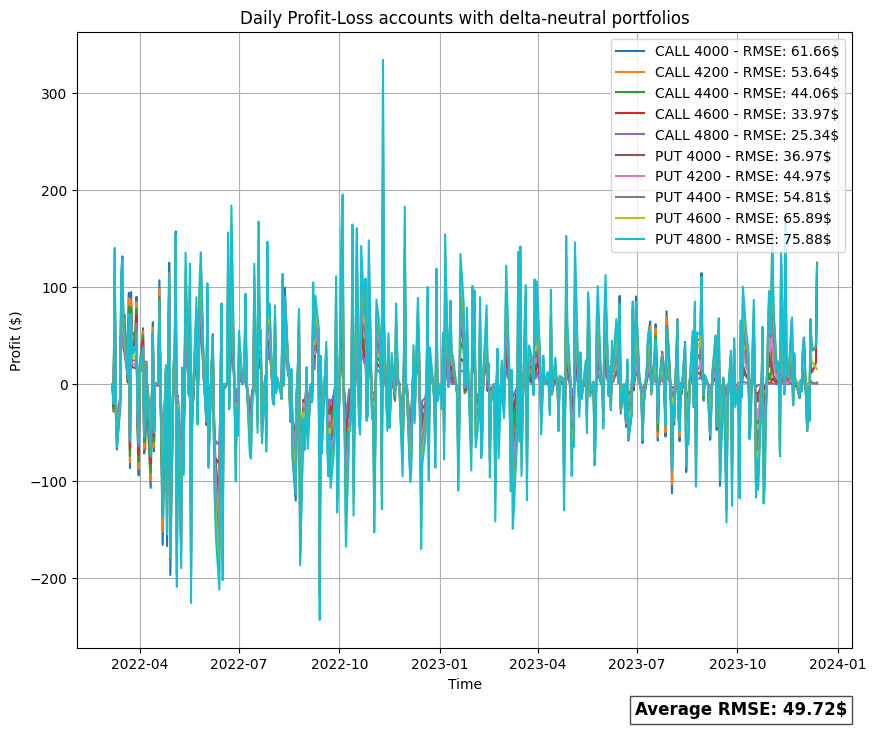

In [ ]:
# =============== P/L PLOTS + RMSE COMPUTATION =============== #

# Show result: plot the P/L accounts for all securities and calculate MSE and RMSE for them
plt.figure(figsize=(10, 8))

pl_accounts = [col for col in delta_hedge_df.columns if 'P/L [DAILY]' in col]
avg_rmse = 0

rmse_list=[]

X = np.array(range(len(delta_hedge_df))).reshape(-1, 1)  # Create a column vector of time
for pl in pl_accounts:

  mse = mean_squared_error(np.zeros(len(delta_hedge_df)), delta_hedge_df[pl])
  rmse = np.sqrt(mse)
  rmse_list.append(rmse)

  y = delta_hedge_df[pl].values.reshape(-1, 1)  # Wealth values
  plt.plot(delta_hedge_df.index, y, label=pl.replace('HEDGE P/L [DAILY]', f"RMSE: {rmse:.2f}$").replace(' ISM DEC23',''))

  avg_rmse += ( rmse / 10 )

plt.xlabel('Time')
plt.ylabel('Profit ($)')
plt.title('Daily Profit-Loss accounts with delta-neutral portfolios')
props = dict(boxstyle='square', facecolor='white', edgecolor='black', alpha=0.7)
plt.text(delta_hedge_df.index[-120], plt.ylim()[1]*(-0.9), f"Average RMSE: {avg_rmse:.2f}$",
         fontsize=12, verticalalignment='top', bbox=props, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

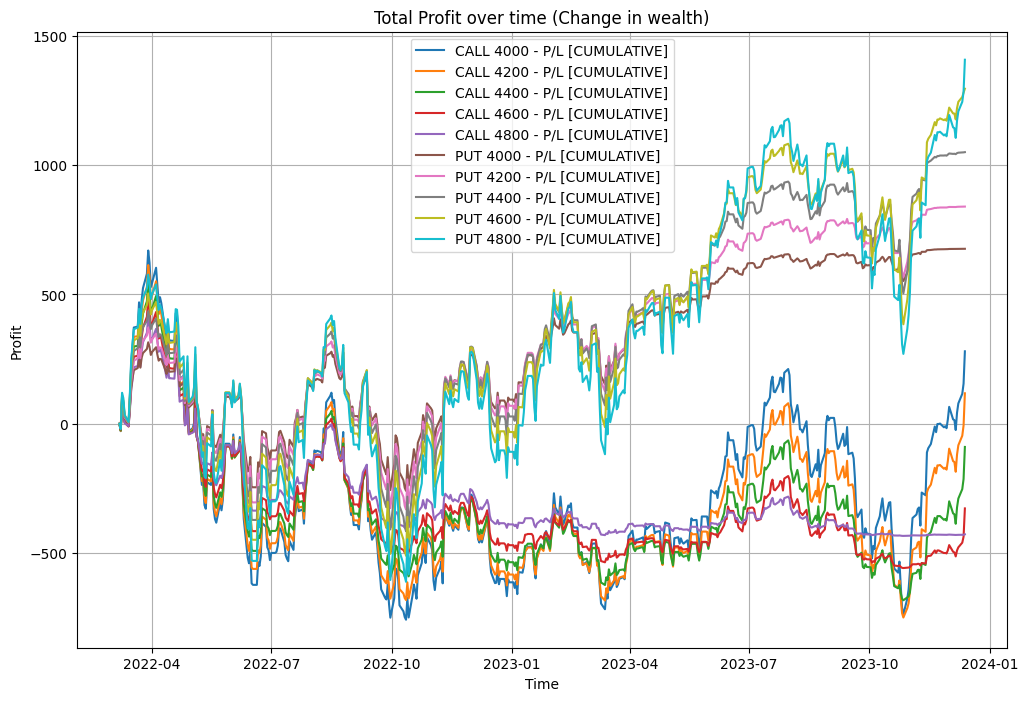

In [ ]:
# ============ TOTAL WEALTH for delta-neutral hedging strategies ============ #

plt.figure(figsize=(12, 8))

total_profits = [col for col in delta_hedge_df.columns if 'P/L [CUMULATIVE]' in col]
total_profits.sort()

for account in total_profits:
  colors = plt.plot(delta_hedge_df.index, delta_hedge_df[account], label=account.replace(' ISM DEC23',''))[0].get_color()

plt.xlabel('Time')
plt.ylabel('Profit')
plt.title('Total Profit over time (Change in wealth)')
plt.legend()
plt.grid(True)

plt.show()

Fitting 3 folds for each of 21 candidates, totalling 63 fits


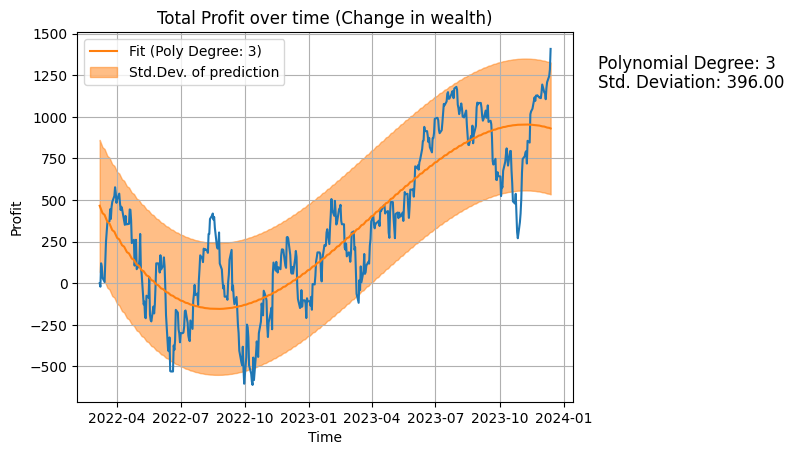

In [ ]:
# ===================== EXTRA: POLYNOMIAL FIT FOR WEALTH ===================== #

# just to see the evolution trend for generated wealth when using the provided deltas

# GridSearchCV for finding the best polynomial degree: try with the first Call
param_grid = {'polynomialfeatures__degree': np.arange(21)}
poly_grid_search = GridSearchCV(make_pipeline(PolynomialFeatures(), LinearRegression()),
                                param_grid=param_grid,
                                cv=3,
                                scoring='neg_mean_squared_error',
                                verbose=1)

# Polynomial fit
X = np.array(range(len(delta_hedge_df))).reshape(-1, 1)  # Create a column vector of time
y = delta_hedge_df['PUT ISM DEC23 4800 - P/L [CUMULATIVE]'].values.reshape(-1, 1)  # Wealth values

# Fit the GridSearchCV
poly_grid_search.fit(X, y)

# Get the best model and predict the values
best_degree = poly_grid_search.best_params_['polynomialfeatures__degree']
best_model = poly_grid_search.best_estimator_
y_poly_pred = best_model.predict(X)

# Calculate the standard deviation of the predictions
y_std = np.std(y_poly_pred, axis=0)

# Plot the series with polynomial fit
plt.plot(delta_hedge_df.index, y)
colors = plt.plot(delta_hedge_df.index, y_poly_pred, label=f'Fit (Poly Degree: {best_degree})')[0].get_color()

# Plot the standard deviation as a shaded region around the polynomial fit
plt.fill_between(delta_hedge_df.index, (y_poly_pred - y_std).flatten(), (y_poly_pred + y_std).flatten(), color=colors, alpha=0.5, label='Std.Dev. of prediction')

plt.annotate(f'Polynomial Degree: {best_degree}', xy=(1.05, 0.9), xycoords='axes fraction', fontsize=12)
plt.annotate(f'Std. Deviation: {y_std[0]:.2f}', xy=(1.05, 0.85), xycoords='axes fraction', fontsize=12)

plt.xlabel('Time')
plt.ylabel('Profit')
plt.title('Total Profit over time (Change in wealth)')
plt.legend()
plt.grid(True)

plt.show()

**2. Alternative Hedging Strategy**

Now we calculate and plot some correlations that may help us better elaborate on the relationships that exist between the underlying mini S&P future and each option written on it. The goal is to devise a pairs trading strategy (hence a valid hedging policy) which may minimize losses incurred at each point in time. Above, we have calculated and stored in the ```'neutral'``` dataframe the "ideal" hedge $\overline{\delta}$, i.e. the futures positions which would indeed make all profit-loss account neutral to realized price shifts.

In other words, we found
$$
\overline{\delta} = \{ \overline{\delta_t} \}_{t=0}^{T-1} \\
\forall t \in \{0, .., T-1\}, \ \ \overline{\delta_t} = \frac{C_{t+1} - C_t}{S_{t+1} - S_t}
$$

Importantly, note that according to our analysis above $\delta_T$ will not affect the result, so it may be set arbitrarily: we do not need prices at $T+1$ bevause at the end of the trading horizon the whole position is immediately liquidated.

**ML hedging**

The theoretical proposal is to approximate the implied optimal hedging policy, represented by the function $f$, through an ANN so that parameters we optimize are those of the neural network, rather than the asset positions themselves:

$$
\delta_{t+1}^* = f_t (t,V_t, S_t, \mathcal{I}_t ) \approx F_\theta ( t,W_t, S_t, \mathcal{I}_t )
$$

We use a custom loss function: we calculate the profit-loss account at each time step depending on the difference between the estimated positions and the ideal ones, and the change in underlying prices.

In [ ]:
# ====================== PREPROCESSING FOR ML ====================== #

df = ready_df.copy()
# print(df.isna().sum()) # indeed there are none

df['Year'] = df['Date.1'].dt.year
df['Month'] = df['Date.1'].dt.month
df['Day'] = df['Date.1'].dt.day
df['DayOfWeek'] = df['Date.1'].dt.dayofweek
df['DayOfYear'] = df['Date.1'].dt.dayofyear
df['WeekOfYear'] = df['Date.1'].dt.isocalendar().week
df['Quarter'] = df['Date.1'].dt.quarter
df['IsWeekend'] = df['Date.1'].dt.dayofweek.isin([5, 6]).astype(int)
df = df.drop(columns=['Date.1'])
df = df.drop(columns=['CME-MINI S&P 500 INDEX CONT. - SETT. PRICE']) #useless

neutral_ = pd.concat([neutral, prices_df['CME-MINI S&P 500 INDEX DEC 2023 - SETT. PRICE'].diff().rename('S_shift')], axis=1)
neutral_['S_shift'].iloc[0]=0

valid_split = 200
test_split = 300

X_train = df.iloc[:test_split].values.astype(np.float32)
#X_valid = df.iloc[valid_split:test_split].values.astype(np.float32)
X_test = df.iloc[test_split:].values.astype(np.float32) # unnormalized tensors
y_train = neutral_.iloc[:test_split].values.astype(np.float32)
#y_valid = neutral_.iloc[valid_split:test_split].values.astype(np.float32)
y_test = neutral_.iloc[test_split:].values.astype(np.float32)

# last column of y contains the shifts in futures prices: will be needed for loss calculation.
# neutral.head()

We are dealing with a time series, so it may be best to first plot the evolution of the perfect hedging positions to understand whether peculiar time trends, seasonality or other features are at play. This will allow to determine whether, for instance, it is appropriate to *difference* the series.

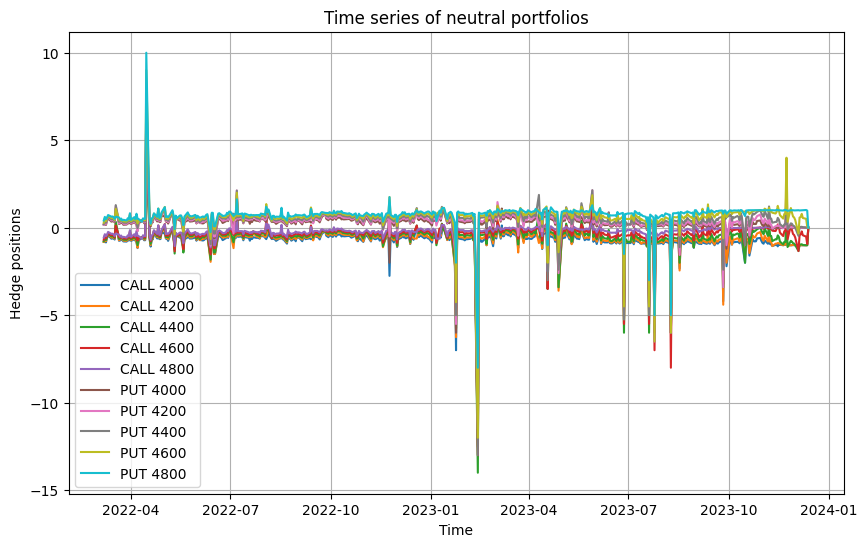

In [ ]:
# ========================= NEUTRAL PORTFOLIOS ========================= #

plt.figure(figsize=(10, 6))

for perfect_hedge in neutral.columns:
  plt.plot(neutral.index, neutral[perfect_hedge].values.reshape(-1, 1),
           label=perfect_hedge.replace('ISM DEC23 ','').replace(' - NEUTRAL ASSET POSITION',''))

plt.xlabel('Time')
plt.ylabel('Hedge positions')
plt.title('Time series of neutral portfolios')
props = dict(boxstyle='square', facecolor='white', edgecolor='black', alpha=0.7)
plt.legend()
plt.grid(True)
plt.show()

It is visible that some perfect hedges represent notable outliers. Indeed, from data inspection one may verify they are not mistakes: prices simply behaved in irregular around those days. For instance,there could be such small underlying price movements, thus resulting in large $\delta$ ratio. It is reassuring to see that indeed such movements are seen for all options under scrutiny.

Construction of the loss function was not trivial since it had to take into account such underlying price changes, which are not a target in themselves. We tried several approaches e.g. using callbacks, but in the end the most straight-forward approach was to include the price shifts in the targets fed to the neural networks. However, these are not used for prediction, only for loss computation.

Since our performance measure depends on profit-loss, and such small movements may not impact portfolio value that heavily, it is straight-forward to conclude that, were a neural net incapable of generalizing to such idiosyncratic shifts, results would not suffer significantly - and this is desirable. To better see this, note that profit-loss at time step $t$ is:
$$
PL_t = M (S_t - S_{t-1}) \left( - \delta_{t-1} + \overline{\delta}_{t-1} \right)
$$

Interestingly, however, we can see that values for both Call and Put options escape the "prescribed" $[0,1]$ range they should lie in: they change sign, and sometimes get much larger.

On the other hand, it seems there is no peculiar seasonal ciclycity nor ascending/descending trends; the series look stationary.

With our data, the task we are concerned with is **one-step ahead forecasting**, which we may best implement through a Keras **sequence-to-vector RNN** architecture, also with a LSTM implementation that may help preserve strongly recurrent features for the whole trading horizon. However, let's begin with something simpler.

*Note on data preprocessing:*

First, we examine the dataset to visualize whether some features are strongly skewed or have otherwise irregular distributions. We avoid unnecessary pipelines: the data contains no missing values, so no imputation is needed; as for scaling,

Were there any missing values, KNN Imputation would be a simple yet sensible choice in this case, because prices and Greeks on options written on the same underlying future are likely interconnected among themselves and with the underlying's price. Additionally, setting hyperparameter ```weights = 'distance'``` would privilege instances closest to those with missing values.

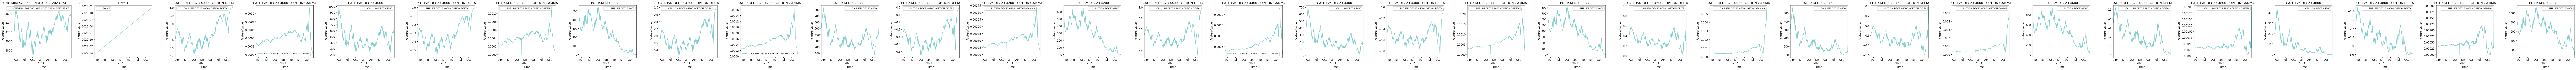

In [ ]:
# ====================== EVOLUTION OF REGRESSORS OVER TIME ====================== #
num_cols = len(ready_df.columns) - 1
fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(5*num_cols, 5))  # Adjust figsize as needed

for i, column in enumerate(ready_df.columns[1:]):
    ready_df.plot(ax=axes[i], y=column, color="#80CCCC")
    axes[i].set_title(column, fontsize=14)  # Set title for each subplot
    axes[i].tick_params(axis='both', which='major', labelsize=12)  # Set tick label size for both axes
    axes[i].set_xlabel("Time", fontsize=12)  # Set x-axis label
    axes[i].set_ylabel("Feature Value", fontsize=12)  # Set y-axis label

plt.tight_layout(pad=3)  # Adjust subplot parameters to give specified padding
plt.show()


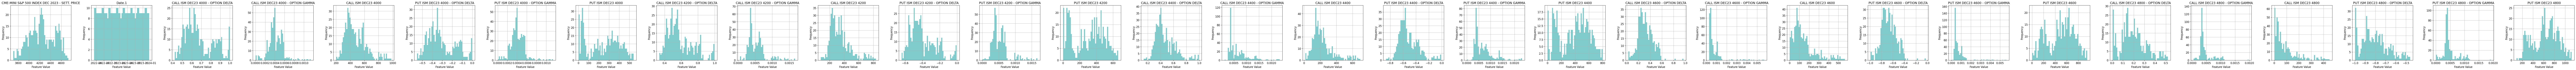

In [ ]:
# ====================== DISTRIBUTIONS OF REGRESSORS ====================== #
num_cols = len(ready_df.columns) -1
fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(5*num_cols, 5))  # Adjust figsize as needed

for i, column in enumerate(ready_df.columns[1:]):
    ready_df[column].hist(ax=axes[i], bins=50, color="#80CCCC")
    axes[i].set_title(column, fontsize=14)  # Set title for each subplot
    axes[i].tick_params(axis='both', which='major', labelsize=12)  # Set tick label size for both axes
    axes[i].set_xlabel("Feature Value", fontsize=12)  # Set x-axis label
    axes[i].set_ylabel("Frequency", fontsize=12)  # Set y-axis label

plt.tight_layout(pad=3)  # Adjust subplot parameters to give specified padding
plt.show()


All features seem mostly normally or uniformly distributed. However, some distributions look multimodal, and some Gammas resemble lognormal distributions. This may call for bucketization or ad-hoc log transformations. We may add these options for fine-tuning in a hyper-model specification.

When features have multimodal distributions, bucketizing them would allow the regression model to more easily learn different rules for different ranges of this feature value.

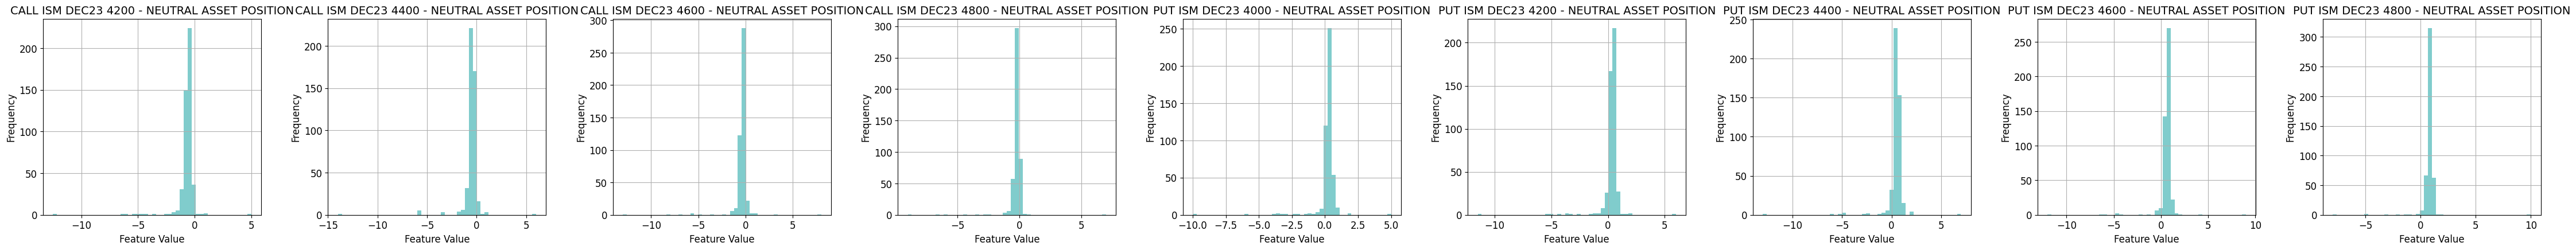

In [ ]:
# ====================== DISTRIBUTIONS OF TARGETS ====================== #
num_cols = len(neutral.columns) -1
fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(5*num_cols, 5))

for i, column in enumerate(neutral.columns[1:]):
    neutral[column].hist(ax=axes[i], bins=50, color="#80CCCC")
    axes[i].set_title(column, fontsize=14)
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].set_xlabel("Feature Value", fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)

plt.tight_layout(pad=3)
plt.show()

The data is split into train and test sets according to the assignment specifications: only the first 300 observations will be used for training. We **do not shuffle the split** so as to preserve the data's time-series nature.

Now that we have prepared the data, we can test some alternative models. We begin with a rather simple Multi-Layer-Perceptron (FNN). We use Keras ```Sequential``` class instead of Sklearn's ```MLPRegressor```, because this allows us to control the output layer activation function. Ideally, we would want all predictions to lie in the interval $[-1,1]$, in accordance with the theory. However, we may test several output layer activation functions, as we have seen that the data structure is in fact irregular. It will be interesting to evaluate whether allowing the model to generalize to atypical outcomes will improve or harm performance, on average.

The output layer contains 10 units, since each $y$ instance is a $10 \times 1 $ vector containing the asset positions needed to hedge each option.

We tried SGD as optimizer, thus using a standard *backpropagation* algorithm. We then implemented Adaptive moment estimation (Adam) due to its efficiency. We begin with a simple MLP constructed using the functional Keras API and consider this as a baseline.

In [ ]:
# ============================== SIMPLE MLP ============================== #

input_deep = tf.keras.layers.Input(shape=[X_train.shape[1]]) # all features
norm_layer = tf.keras.layers.Normalization()
norm_ = norm_layer(input_deep)
hidden1 = tf.keras.layers.Dense(100, activation="relu")(norm_)
output = tf.keras.layers.Dense(10,activation='tanh')(hidden1)

model = tf.keras.Model(inputs=input_deep,outputs=output)

opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss=rmse_pf_loss, optimizer=opt, metrics=rmse_pf_loss)

norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=1000, batch_size=64)

mse_test, rmse_test = model.evaluate(X_test, y_test)

Epoch 1/1000
5/5 [==============================] - 1s 3ms/step - loss: 55.7158 - rmse_pf_loss: 55.1301
Epoch 2/1000
5/5 [==============================] - 0s 3ms/step - loss: 55.9195 - rmse_pf_loss: 55.8311
Epoch 3/1000
5/5 [==============================] - 0s 3ms/step - loss: 55.8062 - rmse_pf_loss: 55.2480
Epoch 4/1000
5/5 [==============================] - 0s 3ms/step - loss: 56.0873 - rmse_pf_loss: 55.3119
Epoch 5/1000
5/5 [==============================] - 0s 2ms/step - loss: 54.9180 - rmse_pf_loss: 57.5974
Epoch 6/1000
5/5 [==============================] - 0s 2ms/step - loss: 55.6858 - rmse_pf_loss: 55.1979
Epoch 7/1000
5/5 [==============================] - 0s 2ms/step - loss: 55.9109 - rmse_pf_loss: 55.0325
Epoch 8/1000
5/5 [==============================] - 0s 4ms/step - loss: 55.2947 - rmse_pf_loss: 54.0604
Epoch 9/1000
5/5 [==============================] - 0s 2ms/step - loss: 55.3203 - rmse_pf_loss: 54.2714
Epoch 10/1000
5/5 [==============================] - 0s 2ms/step

6/6 [==============================] - 0s 2ms/step


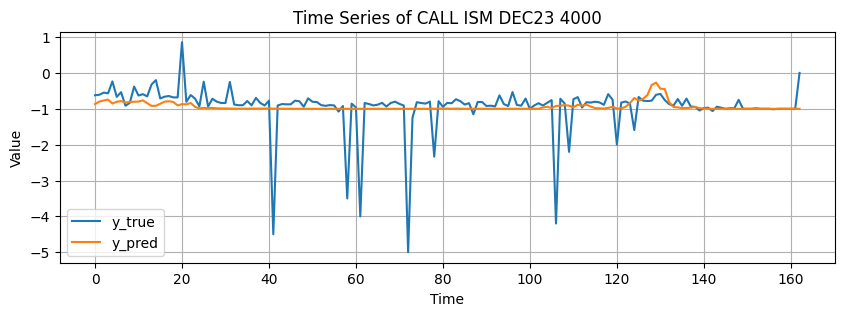

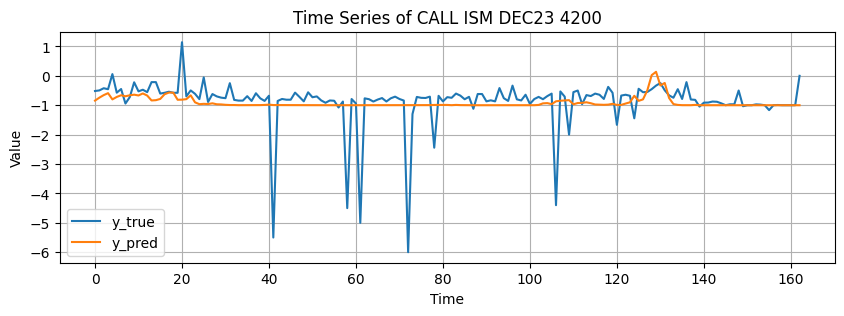

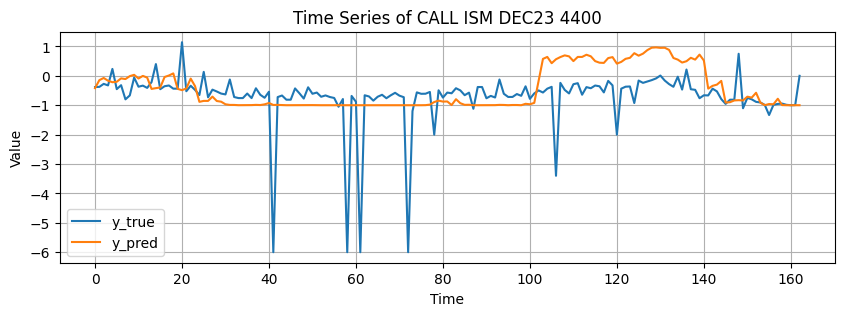

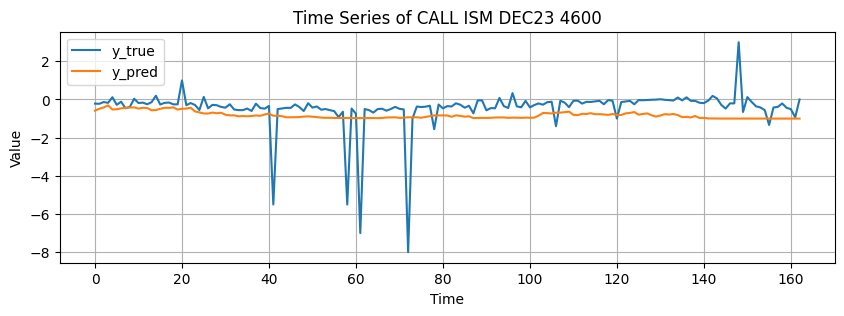

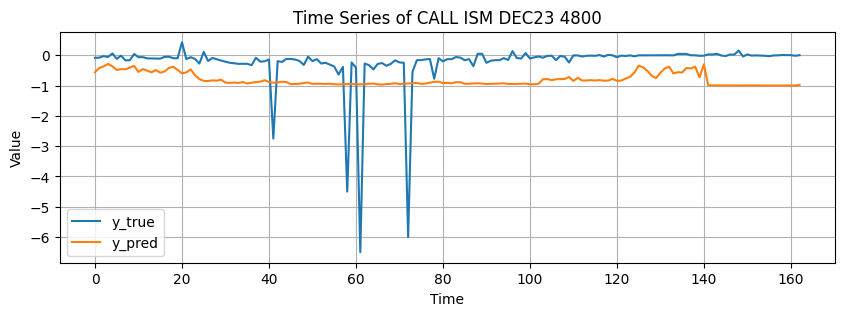

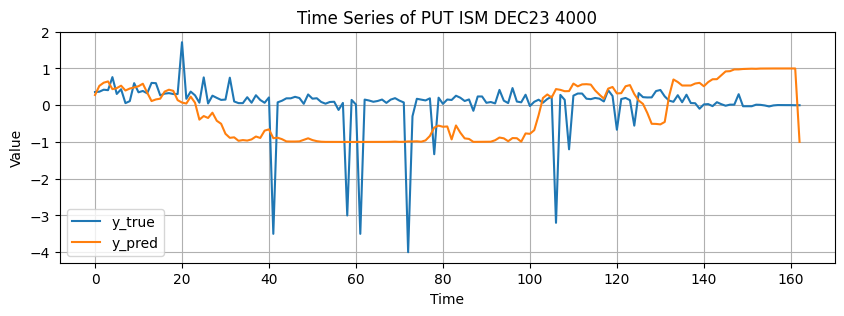

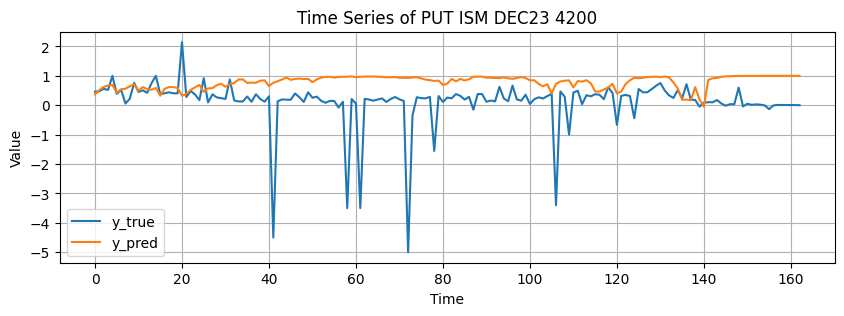

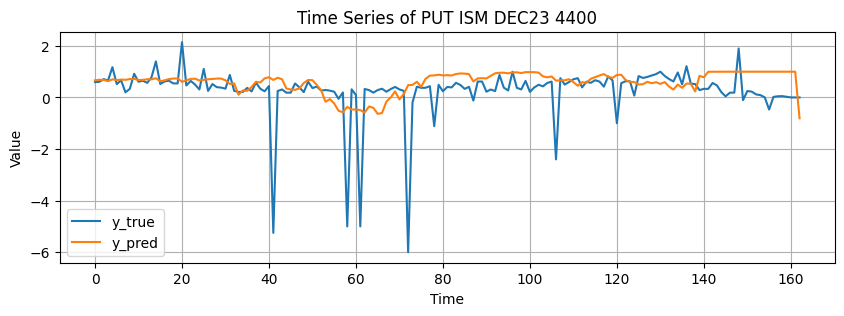

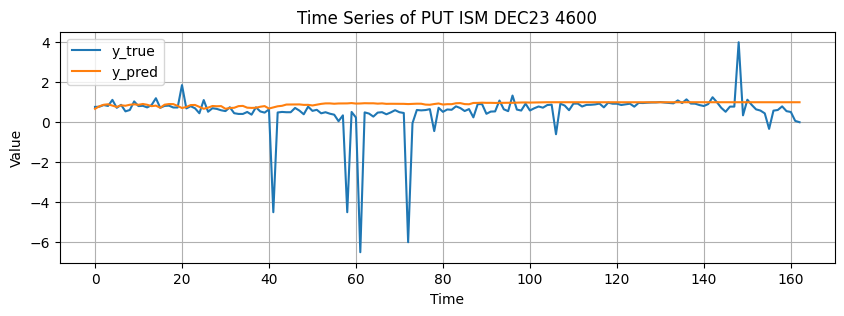

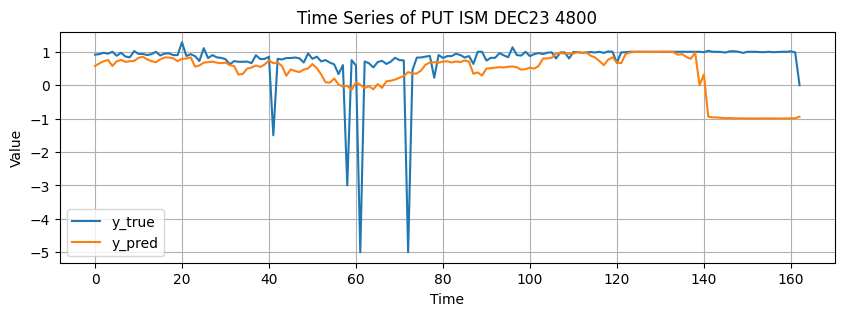

In [ ]:
# ============================ PLOT PRED VS TRUE ============================ #

y_pred=model.predict(X_test)

for i in range(y_test.shape[1]-1):
  plt.figure(figsize=(10, 3))

  # Plot y_true and y_pred for the current feature
  plt.plot(y_test[:, i], label='y_true')
  plt.plot(y_pred[:, i], label='y_pred')

  plt.title(f"Time Series of {options[i].replace('ISM DEC 23 ','')}")
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.grid(True)
  plt.show()

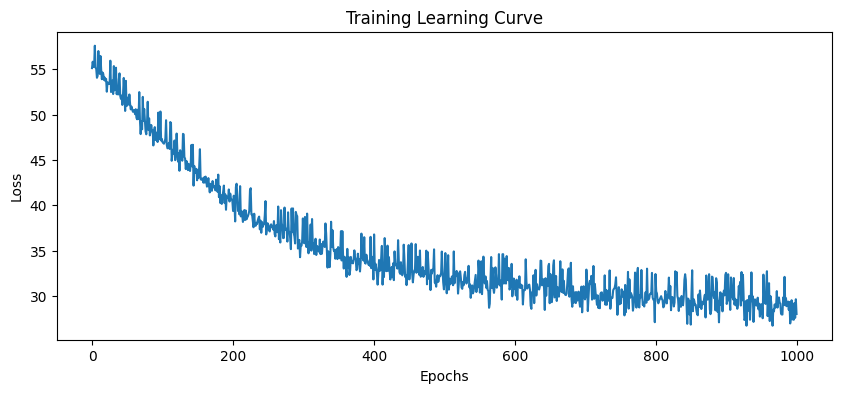

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history.history['rmse_pf_loss'], label='Training Loss')
plt.title('Training Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Training this model results in much gradient instability, as can be seen from the jumping around of the training Learning curve. We tried several tuners on most model hyperparameters (```kt.Hyperband, kt.BayesianOptimizer```) but none would return hyperparameter combinations that would outperform the original MLP.

3) Results improve with respect to task (1); despite the fit is far from perfect, we obtain better RMSE than in the delta-hedging exercise. In our last run, the test RMSE was approximately 32.58 - though convergence is imperfect due to gradient instability - while the delta-hedging result was around 49. Previous runs would show, however, that in many cases even simple "naive" strategies (such as (1,1) portfolios over the whole time period, in some cases) would still outperform continuous re-balancing based on the provided deltas.

4) Our results are not the most satisfactory, because we were not able to test many models the way we intended. It was already noted that tuners for MLP architecture were not precise enough, so we tweaked hyperparameters manually. We fell short of the objective both because of the size of the dataset and because the effect of price shifts on the value of the loss function amplified the gradient instability problem. We would need much more time and resources to fine-tune these aspects.

*Inter alia*, we tried running a RNN architecture, which would have been the most appropriate choice for modelling the recurrent interaction of hedging positions. This observation stems from the fact that considerable wide-spread market mistakes prompt a large portion of agents to rebalance, thus affecting dynamically the interdependence between option and underlying prices. However, the RNN did not succeed.

In general, we originally ran all the "ML code" by splitting the train data into proper train *and* validation sets, but this would just magnify the overfitting problem. Indeed, both 200 and 300 observations are not quite enough to keep in check the neural network and ensure it generalizes properly. In the original run, the train set would be fit almost perfectly, with wonderful plots, and and $RMSE \leq 10$ - however, predictions on the validation and test sets would fail miserably.

Although the final plots show that results are far from the ideal, evaluation of the model shows it performs slightly better and in fact beats the delta-hedging performance. This is remarkable given that we did use the ```tanh``` activation function, which restricts by default the range of values the asset positions can take. We manually reduced the learning rate and tweaked the activation function; indeed, although tanh distorts predictions, restricting the range of output values helped avoid overfitting on outliers.

The idea to take home with this assignment is that "statistical arbitrage" on pairs trading may indeed yield great results and often outperform more mechanic strategies that rely on theoretical computations that are, indeed, approximations (for instance it is not clear the extent to which the provided deltas shield from bid-ask spreads or similar features of the financial market); on the other hand, a stripped-to-the-essentials ML architecture, which doesn't even rely on large volumes of data, is unlikely to perform well and shall thus be evaluated carefully.